# Multi-armed Bandits problem

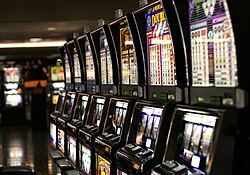

There is only a single state and we have to find globally optimal best action

The bandit problem focuses purely on the credit assignment problem (which action was good?), while MDPs add the temporal credit assignment problem (which action was good, and when?).

A room with N (multi-armed) bandits, and are tasked to maximize our returns when playing these for a fixed amount of time. 

- Each bandit only allows one action, namely pulling the designated lever / arm. 
- When doing so, we obtain a specific reward, which follows a Gaussian distribution with a fixed mean / variance. 

If there was no randomness involved, one would simply try every machine once, and then continue playing the best bandit. 
However, since we do not have access to the true reward distribution, we face an exploration vs exploitation dilemma.

**Exploitation vs exploration**

At every timestep we can be greedy, and exploit knowledge we have collected so far — such as playing that machine which empirically — up to now — yielded the most returns. 
Risk of missing out on other, potentially even better machines we discovered less so far. 

Therefore, it can be beneficial to explore more of the environment.

compute and store values of states and actions, 
- state-value function $v(s)$ : the “goodness” of a certain state (v)
- action-value function $q(s, a)$: goodness” of taking action a in state s (q).

If we have found these values -> policy yielding optimal returns: 

    -> in each state, simply take the action corresponding to the highest q value. 
    
That might make sense intuitively — and in a later episode we will also formally show why such a greedy approach indeed yields the optimal result

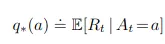

 optimal value of taking action a (which denotes playing the bandit corresponding to this index) should equal the expected return from the underlying reward distribution

So estimate values using sample means: 

 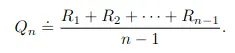
 
Naive computation we would need to hold all previous results in memory — and using some simple reformulation we can reduce this to O(1) memory and an iterative formula

 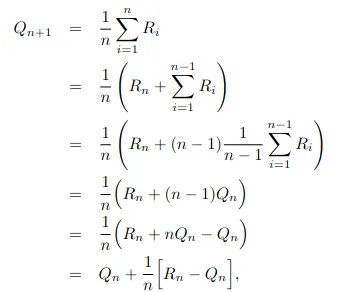

 -> PATTERN in RL:

 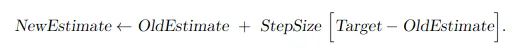

 Here: StepSize = 1/n assigns uniform weight to all observed rewards — which makes sense for multi-armed bandits, as rewards do not change over time

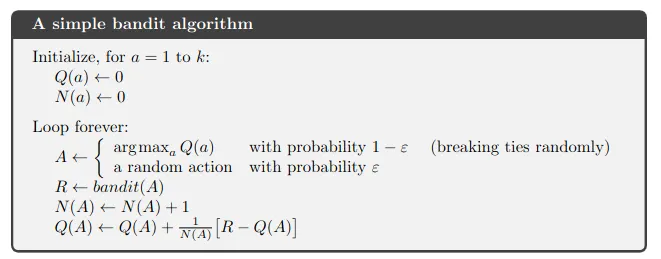

Q and N, to save estimated state values and action execution frequencies. 

We then continuously increment the value estimates, following an ε-greedy policy: with probability 1 — ε we exploit the current best action, with probability ε we explore a random action

/var/folders/p4/b3p9tbn949714k6ymvrnpslm0000gq/T/ipykernel_65451/1511827604.py:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Q[A] = Q[A] + 1 / N[A] * (R - Q[A])


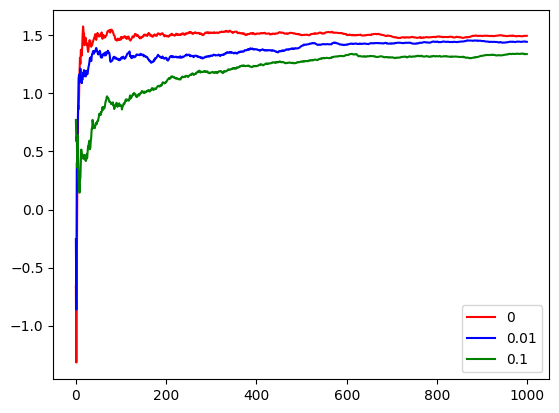

In [8]:
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np

NUM_STEPS = 1000


class Bandit:
    def __init__(self, mu: float, sigma: float = 1) -> None:
        self.mu = mu
        self.sigma = sigma

    def __call__(self) -> np.ndarray:
        return np.random.normal(self.mu, self.sigma, 1)


def initialize_bandits() -> list[Bandit]:
    return [
        Bandit(0.2),
        Bandit(-0.8),
        Bandit(1.5),
        Bandit(0.4),
        Bandit(1.1),
        Bandit(-1.5),
        Bandit(-0.1),
        Bandit(1),
        Bandit(0.7),
        Bandit(-0.5),
    ]


def simple_crit(Q: np.ndarray, N: np.ndarray, t: int, eps: float) -> int:
    return (
        int(np.argmax(Q))
        if np.random.rand() < 1 - eps
        else np.random.randint(Q.shape[0])
    )


def ucb_crit(Q: np.ndarray, N: np.ndarray, t: int, c: float) -> int:
    return int(np.argmax(Q + c * np.sqrt(np.log(t) / N)))


def bandit_solver(
    bandits: list[Bandit], crit: Callable[[np.ndarray, np.ndarray, int], int]
) -> np.ndarray:
    Q = np.zeros((len(bandits)))
    N = np.zeros((len(bandits)))

    rewards = []
    for t in range(NUM_STEPS):
        A = crit(Q, N, t)
        R = bandits[A]()
        rewards.append(R)
        N[A] = N[A] + 1
        Q[A] = Q[A] + 1 / N[A] * (R - Q[A])

    return np.cumsum(rewards) / np.arange(1, len(rewards) + 1)


bandits = initialize_bandits()
epss = [0, 0.01, 0.1]
reward_averages = [
    bandit_solver(bandits, lambda q, n, t: simple_crit(q, n, t, eps)) for eps in epss
]
colors = ["r-", "b-", "g-"]
for idx, reward_average in enumerate(reward_averages):
    plt.plot(range(len(reward_average)), reward_average, colors[idx], label=epss[idx])
plt.legend()
plt.savefig("plot.png")
